In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-04 20:14:36.239006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 20:14:36.239160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 20:14:36.397975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.15.0
TensorFlow Decision Forests v1.8.1


In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
df = pd.read_csv(train_file_path)
print(df.shape)

(1460, 81)


In [4]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


****There are 79 feature columns. Using these features the model has to predict the house sale price indicated by the label column named SalePrice.****

> ### No Need for ***Id*** Column

In [5]:
df = df.drop('Id', axis=1)
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# Step 1: Data Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 1. Handle Missing Values: Identify and handle missing values appropriately.

>- Drop columns with a high percentage of missing values.
>- Fill missing values in numerical columns with the median or mean.
>- Fill missing values in categorical columns with the mode.

### House Price Distribution
>- We are checking how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_18/3453550780.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


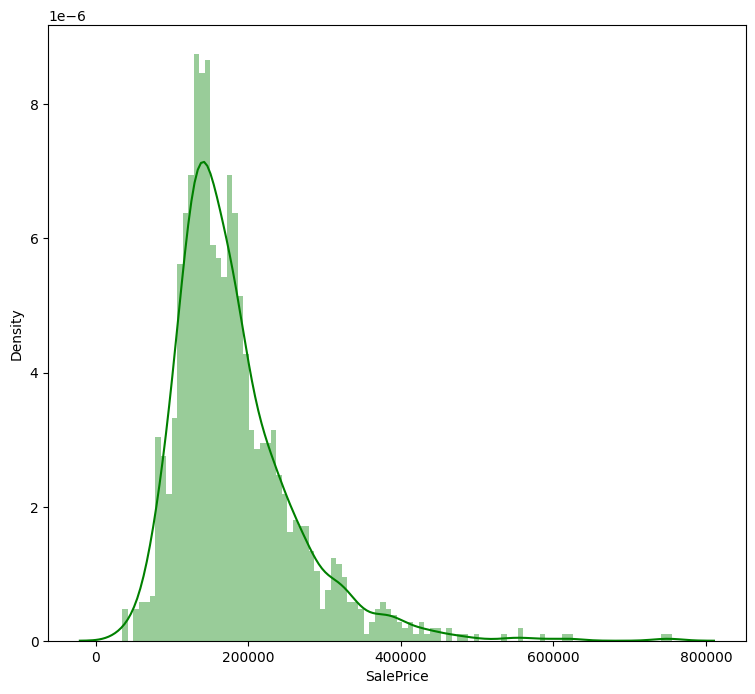

In [7]:
print(df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

### Numerical data distribution¶
>- We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [8]:
list(set(df.dtypes.tolist()))


[dtype('int64'), dtype('float64'), dtype('O')]

In [9]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


##### Now we are checking distribution of all numerical features.

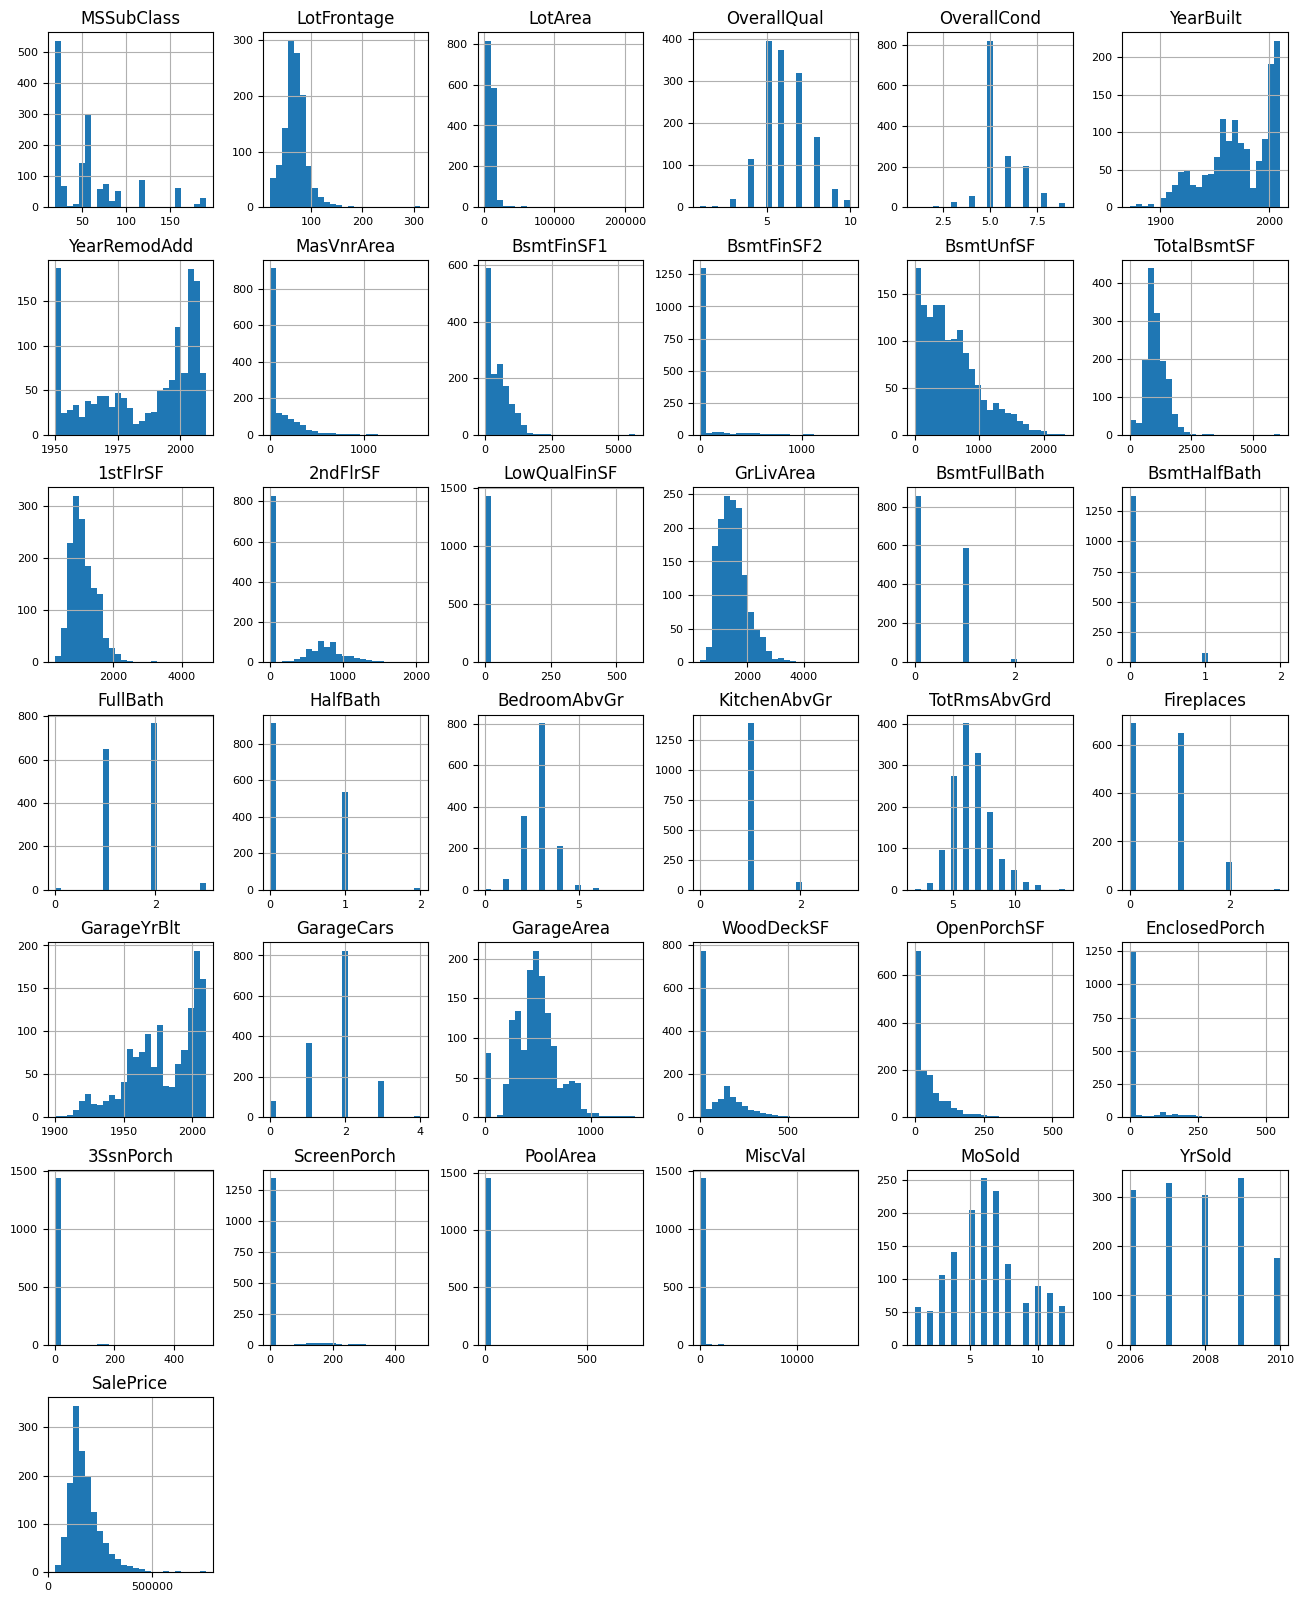

In [10]:
df_num.hist(figsize=(16, 20), bins=25, xlabelsize=8, ylabelsize=8);